In [23]:
df = pd.read_csv("/content/food_dataset_realistic.csv")

In [24]:
df.columns = df.columns.str.strip().str.lower()

In [25]:
print(df.head(), "\n")

                                         ingredients        label  calories  \
0  salt, corn syrup, sugar, chocolate, mayonnaise...  Weight Loss       351   
1  whey isolate, chia seeds, low fat yogurt, cucu...  Weight Loss       131   
2  cucumber, spinach powder, lentils, flax seeds,...  Weight Loss       137   
3                 chocolate, palm oil, refined flour  Weight Gain       376   
4  milk solids, yeast, palm oil, vegetable oil, c...  Weight Gain       351   

   protein  carbs  fiber  fat  sugar  
0        6     60      4   20     32  
1       19      7      8    2      3  
2       23     20      3    8      0  
3        6     69      5   27     29  
4        8     60      4   24     14   



In [36]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ingredients  1040 non-null   object
 1   label        1040 non-null   object
 2   calories     1040 non-null   int64 
 3   protein      1040 non-null   int64 
 4   carbs        1040 non-null   int64 
 5   fiber        1040 non-null   int64 
 6   fat          1040 non-null   int64 
 7   sugar        1040 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 65.1+ KB
None


In [37]:
print(df.describe(include="all"))

                     ingredients        label     calories      protein  \
count                       1040         1040  1040.000000  1040.000000   
unique                      1032            2          NaN          NaN   
top     sugar, milk solids, salt  Weight Gain          NaN          NaN   
freq                           2          522          NaN          NaN   
mean                         NaN          NaN   314.002885    11.513462   
std                          NaN          NaN   152.497214     6.398373   
min                          NaN          NaN   100.000000     3.000000   
25%                          NaN          NaN   177.750000     6.000000   
50%                          NaN          NaN   291.000000    10.000000   
75%                          NaN          NaN   451.250000    17.000000   
max                          NaN          NaN   599.000000    25.000000   

              carbs        fiber          fat        sugar  
count   1040.000000  1040.000000  1040

In [38]:
print(df.isnull().sum())

ingredients    0
label          0
calories       0
protein        0
carbs          0
fiber          0
fat            0
sugar          0
dtype: int64


In [39]:
text_col = "ingredients"
num_cols = ["sugar", "fat", "protein", "calories", "carbs", "fiber"]
target_col = "label"

In [40]:
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

In [41]:
X_text = df[text_col]
X_num = df[num_cols]
y = df[target_col]

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

In [42]:
tfidf = TfidfVectorizer(stop_words="english", max_features=800)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)


In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)


In [44]:
noise_train = np.random.normal(0, 0.02, size=X_train_scaled.shape)
noise_test = np.random.normal(0, 0.02, size=X_test_scaled.shape)

X_train_scaled_noisy = X_train_scaled + noise_train
X_test_scaled_noisy = X_test_scaled + noise_test

In [45]:
X_train_combined = hstack([X_train_tfidf, X_train_scaled_noisy])
X_test_combined = hstack([X_test_tfidf, X_test_scaled_noisy])


In [46]:
model = LogisticRegression(
    max_iter=2000,
    C=0.1,
    penalty="l2",
    class_weight="balanced"
)

model.fit(X_train_combined, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=2000)

In [47]:
train_acc = accuracy_score(y_train, model.predict(X_train_combined))
test_acc = accuracy_score(y_test, model.predict(X_test_combined))

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test  Accuracy: {test_acc*100:.2f}%\n")

Train Accuracy: 96.63%
Test  Accuracy: 96.63%



In [48]:
y_pred = model.predict(X_test_combined)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)



Confusion Matrix:
 [[ 95   5]
 [  2 106]]


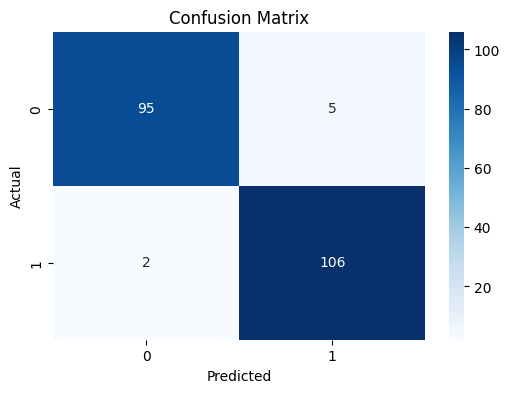

In [49]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



Classification Report:

              precision    recall  f1-score   support

 Weight Gain       0.98      0.95      0.96       100
 Weight Loss       0.95      0.98      0.97       108

    accuracy                           0.97       208
   macro avg       0.97      0.97      0.97       208
weighted avg       0.97      0.97      0.97       208



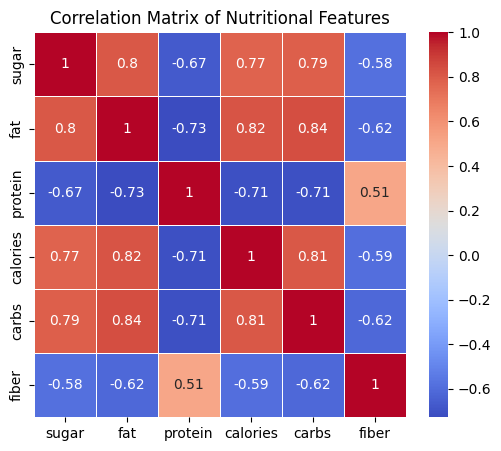

In [51]:
plt.figure(figsize=(6,5))
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix of Nutritional Features")
plt.show()

In [52]:
combo = {
    "model": model,
    "vectorizer": tfidf,
    "scaler": scaler
}

with open("food_model.pkl", "wb") as f:
    pickle.dump(combo, f)



In [54]:
sample_data = {
    "ingredients": "oats honey banana milk",
    "sugar": 12.3,
    "fat": 5.4,
    "protein": 4.8,
    "calories": 210,
    "carbs": 32.6,
    "fiber": 5.1
}

X_text_new = tfidf.transform([sample_data["ingredients"]])

X_num_new = scaler.transform([[
    sample_data["sugar"],
    sample_data["fat"],
    sample_data["protein"],
    sample_data["calories"],
    sample_data["carbs"],
    sample_data["fiber"]
]])

X_new_combined = hstack([X_text_new, X_num_new])
prediction = model.predict(X_new_combined)

print("\nPredicted Class for Sample:", prediction[0])



Predicted Class for Sample: Weight Loss


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
